In [1]:
import cv2

In [2]:
cv2.BORDER_CONSTANT

0

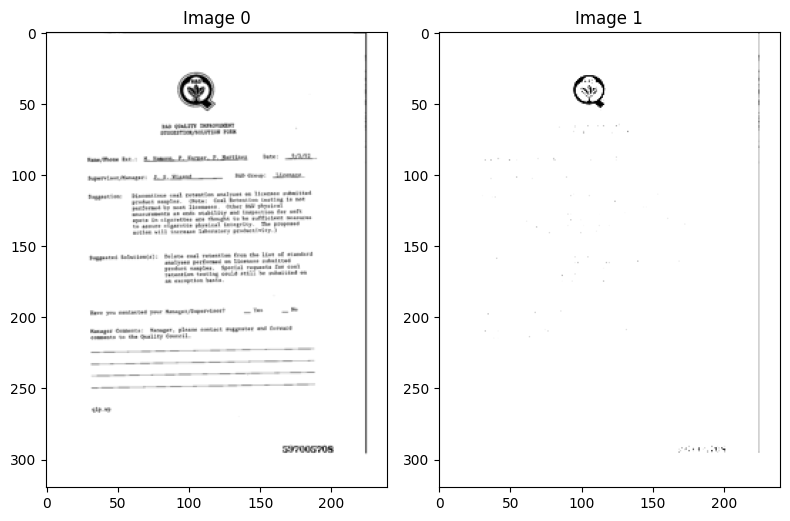

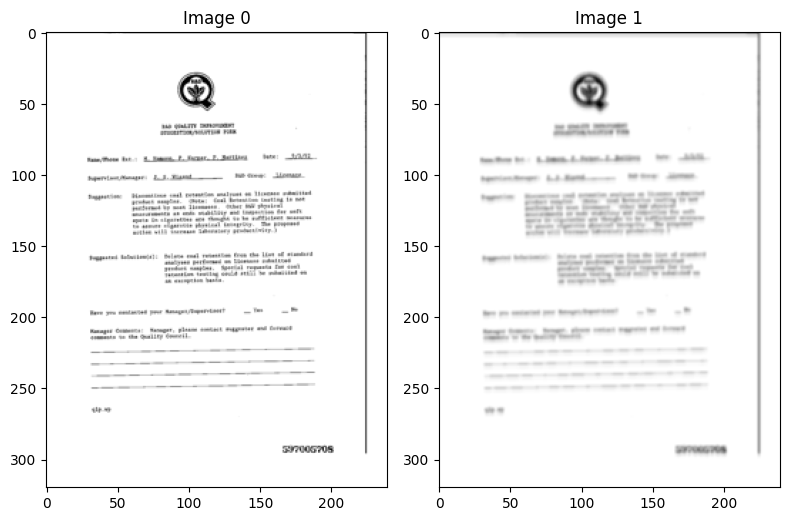

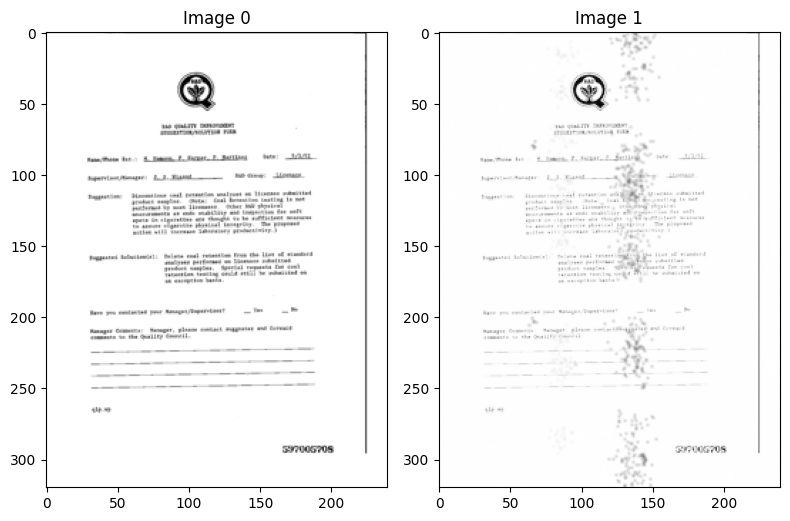

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch = 0, train_loss = 0.8891930146650835 training duration = 8 seconds acc = 0.8772770853307766
Epoch = 1, train_loss = 0.5352540822191671 training duration = 6 seconds acc = 0.909875359539789
Epoch = 2, train_loss = 0.4063210891503276 training duration = 7 seconds acc = 0.9156279961649089
Epoch = 3, train_loss = 0.3568932314713796 training duration = 7 seconds acc = 0.9338446788111218
Epoch = 4, train_loss = 0.3160105792410446 training duration = 6 seconds acc = 0.9434324065196549
Epoch = 5, train_loss = 0.2729923908006061 training duration = 6 seconds acc = 0.9530201342281879
Epoch = 6, train_loss = 0.24794828857887874 training duration = 7 seconds acc = 0.9395973154362416
Epoch = 7, train_loss = 0.2674488621114781 training duration = 6 seconds acc = 0.9453499520613614
Epoch = 8, train_loss = 0.24710432214267325 training duration = 6 seconds acc = 0.9290508149568553
Epoch = 9, train_loss = 0.27143602750518103 training duration = 6 seconds acc = 0.9453499520613614
Epoch = 10, train_

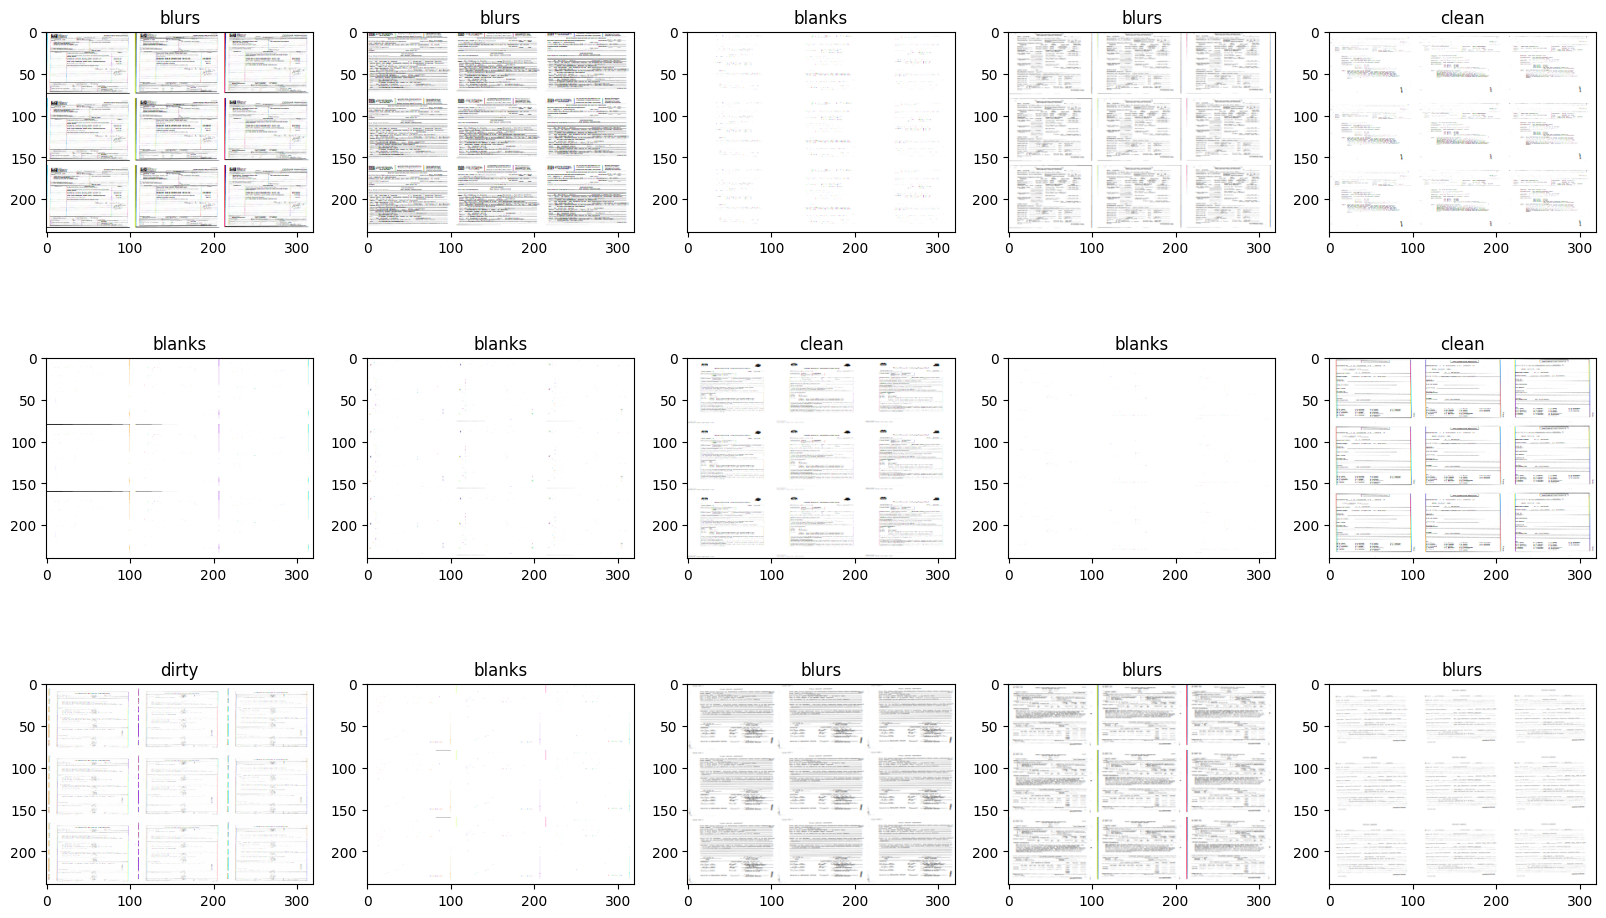

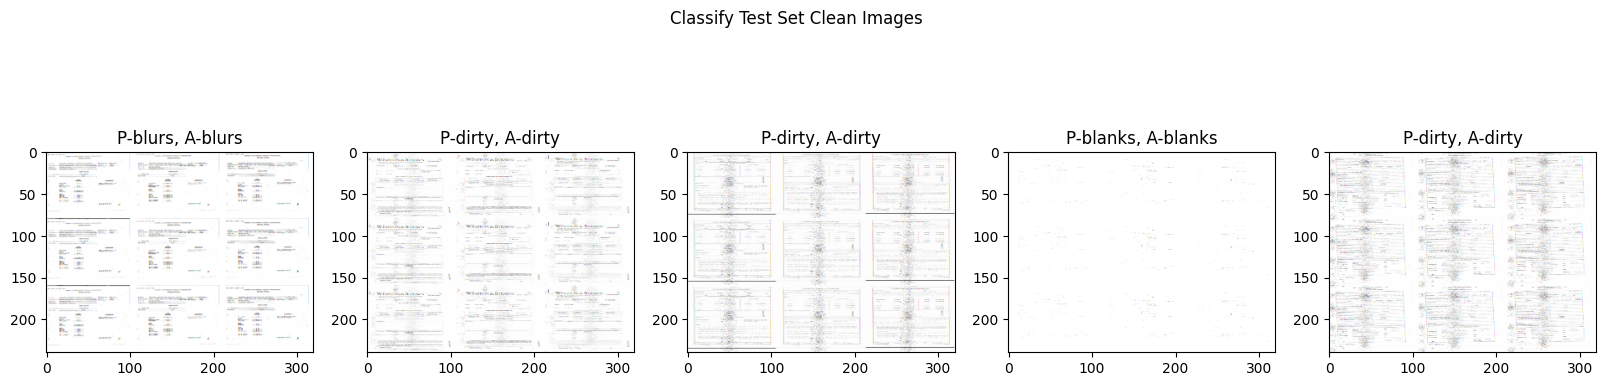

In [3]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

import matplotlib.pyplot as plt

## imports

import torch
from torch import nn

from PIL import Image
import numpy as np

# from noisy_doc_clf

## config

dir_data = "../data/FUNSD/"
dir_data_raw = f"{dir_data}/training_data/raw"

SIZE = (240, 320)

## utils

def plot(img, figsize=(10, 2), cmap="gray", **kwargs):
    show_image(img, figsize=figsize, cmap=cmap, **kwargs)

def plot_multiple(list_images, list_titles=None, cmap="gray", 
                  grid=False, num_cols=2, figsize=(8, 10), title_fontsize=12,):
    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):
        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()



## eda

image_files = list(Path(dir_data_raw).iterdir())

img = Image.open(image_files[3]).resize(SIZE)

img_arr = np.array(img)

img

## transforms

from augraphy import *
import random

### misc

ink_phase = [

    InkBleed(
        intensity_range=(0.1, 0.2),
        kernel_size=random.choice([(1, 1), (1, 3)]),
        severity=(0.05, 0.1),
        p=0.33,
    ),
    OneOf(
        [
           
            BleedThrough(
                intensity_range=(0.05, 0.1),
                color_range=(32, 224),
                ksize=(1, 3),
                sigmaX=1,
                alpha=random.uniform(0.05, 0.1),
                offsets=(1, 2),
            ),
        ],
        p=1.0,
    ),
]

paper_phase = [
            OneOf(
        [
            DelaunayTessellation(
                n_points_range=(50, 80),
                n_horizontal_points_range=(50, 80),
                n_vertical_points_range=(50, 80),
                noise_type="random",
                color_list="default",
                color_list_alternate="default",
            ),
            VoronoiTessellation(
                mult_range=(5, 8),
                seed=19829813472,
                num_cells_range=(50, 100),
                noise_type="random",
                background_value=(200, 255),
            ),
        ],
        p=0.3,
    ),
    # AugmentationSequence(
    #     [
    #         NoiseTexturize(
    #             sigma_range=(1, 3),
    #             turbulence_range=(1, 3),
    #         ),
    #         BrightnessTexturize(
    #             texturize_range=(0.9, 0.99),
    #             deviation=0.03,
    #         ),
    #     ],
    # ),
]

post_phase = [
    OneOf(
        [
            DirtyDrum(
                line_width_range=(1, 2),
                line_concentration=random.uniform(0.05, 0.15),
                direction=random.randint(0, 2),
                noise_intensity=random.uniform(0.6, 0.95),
                noise_value=(64, 224),
                ksize=random.choice([(1, 1), (3, 3), (5, 5)]),
                sigmaX=0,
                p=0.2,
            ),
        ],
        p=1.0,
    ),
    SubtleNoise(
        subtle_range=random.randint(1, 5),
        p=0.33,
    ),
    Jpeg(
        quality_range=(25, 95),
        p=0.33,
    ),

    OneOf(
        [
            Markup(
                num_lines_range=(2, 4),
                markup_length_range=(0.5, 1),
                markup_thickness_range=(1, 2),
                markup_type=random.choice(["strikethrough", "crossed", "highlight", "underline"]),
                markup_color="random",
                single_word_mode=False,
                repetitions=1,
            ),
            Scribbles(
                scribbles_type="random",
                scribbles_location="random",
                scribbles_size_range=(3, 10),
                scribbles_count_range=(1, 3),
                scribbles_thickness_range=(1, 3),
                scribbles_brightness_change=[32, 64, 128],
                scribbles_text="random",
                scribbles_text_font="random",
                scribbles_text_rotate_range=(0, 360),
                scribbles_lines_stroke_count_range=(1, 6),
            ),
        ],
        p=0.4,
    ),
    BadPhotoCopy(
        noise_type=-1,
        noise_side="random",
        noise_iteration=(1, 2),
        noise_size=(1, 3),
        noise_value=(128, 196),
        noise_sparsity=(0.1, 0.3),
        noise_concentration=(0.1, 0.3),
        blur_noise=random.choice([True, False]),
        blur_noise_kernel=random.choice([(1, 1), (3, 3)]),
        wave_pattern=random.choice([True, False]),
        edge_effect=random.choice([True, False]),
        p=0.33,
    ),

            Faxify(
        scale_range=(0.1, 0.2),
        monochrome=random.choice([0, 1]),
        monochrome_method="random",
        monochrome_arguments={},
        halftone=random.choice([0, 1]),
        invert=1,
        half_kernel_size=random.choice([(1, 1), (2, 2)]),
        angle=(0, 360),
        sigma=(1, 3),
        p=0.33,
    ),
]

pipeline = AugraphyPipeline(ink_phase=ink_phase, paper_phase=paper_phase, post_phase=post_phase)

# ink phase
bt_heavy = BleedThrough(intensity_range=(0.8, 0.9),
                        color_range=(80, 128),
                        ksize=(3, 3),
                        sigmaX=1,
                        alpha=random.uniform(0.1, 0.2),
                        offsets=(2, 4), p=0.8)


lines_heavy = NoisyLines(noisy_lines_direction = "random",
                        noisy_lines_location = "random",
                        noisy_lines_number_range = (2, 4),
                        noisy_lines_color = (50,  50 , 50),
                        noisy_lines_thickness_range = (1, 3),
                        noisy_lines_random_noise_intensity_range = (0.1, 0.2),
                        noisy_lines_length_interval_range = (3, 500),
                        noisy_lines_gaussian_kernel_value_range = (3, 5),
                        noisy_lines_overlay_method = "ink_to_paper", p=1.0)


# post phase

fold_heavy = Folding(p=0.3)

bp_heavy = BadPhotoCopy(noise_type=1,
                       noise_side="all",
                       noise_iteration=(1, 2),
                       noise_size=(1, 2),
                       noise_value=(4, 8),
                       noise_sparsity=(0.05, 0.1),
                       noise_concentration=(0.05, 0.1),
                       blur_noise=0,
                       wave_pattern=0,
                       edge_effect=0, p=1.0)

lg = LightingGradient(light_position=None,
                 direction=None,
                 max_brightness=255,
                 min_brightness=0,
                 mode="gaussian",
                 linear_decay_rate=None,
                 transparency=None,
                 p=0.1)

ink_phase = [
       bt_heavy,
    lines_heavy
    # lp_heavy
]

paper_phase = [
	PaperFactory(),
]
post_phase = [
    fold_heavy,
    bp_heavy,
    lg,
]

heavy_pipe = AugraphyPipeline(ink_phase=ink_phase, paper_phase=paper_phase, post_phase=post_phase)

### blank tfm

blank = Brightness(brightness_range=(1.8, 3.0),
                                # min_brightness=0,
                                min_brightness_value=(230, 255),
                        )

plot_multiple([img_arr, blank(img_arr)])

### blur tfm

blur = DoubleExposure(gaussian_kernel_range=(1, 3),
                        offset_direction=1,
                        offset_range=(2, 4),
                    )

plot_multiple([img_arr, blur(img_arr)])

### scan lines

import cv2

dirty = pipeline(cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR))

plot_multiple([img_arr, dirty])

## generate ds

from tqdm.autonotebook import tqdm

from torchvision.transforms import Compose

def tfm_folder(folder, tfm, save_dir):
    files = [x for x in Path(folder).iterdir() if not x.name.startswith(".")]
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    for img_file in tqdm(files):
        if img_file.parent.name.startswith("."): continue
        img = tfm(Image.open(img_file))
        Image.fromarray(img).save(save_dir.joinpath(f"blank_{img_file.name}"))

## generate clean resized

dir_data_clean = Path(dir_data_raw).parent.joinpath("classes/clean").as_posix()
dir_data_clean

rsz_tfms = Compose([
    lambda x: np.array(x.convert("RGB").resize(SIZE)),
])

tfm_folder(dir_data_raw, rsz_tfms, dir_data_clean)

### generate blanks

dir_data_blanks = Path(dir_data_clean).parent.joinpath("blanks").as_posix()
dir_data_blanks

blanks_tfms = Compose([
    lambda x: np.array(x.convert("RGB").resize(SIZE)),
    lambda x: blank(x)
])

tfm_folder(dir_data_clean, blanks_tfms, dir_data_blanks)

### generate blurs

dir_data_blurs = Path(dir_data_clean).parent.joinpath("blurs").as_posix()
dir_data_blurs

blurs_tfms = Compose([
    lambda x: np.array(x.convert("RGB").resize(SIZE)),
    lambda x: blur(x)
])

tfm_folder(dir_data_clean, blurs_tfms, dir_data_blurs)

### generate dirty

dir_data_dirty = Path(dir_data_clean).parent.joinpath("dirty").as_posix()
dir_data_dirty

dirty_tfms = Compose([
    lambda x: np.array(x.convert("RGB").resize(SIZE)),
    lambda x: pipeline(x)
])

tfm_folder(dir_data_clean, dirty_tfms, dir_data_dirty)

## dls

from torchvision import transforms, datasets

BS = 16

tfms = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(root=Path(dir_data_raw).parent.joinpath("classes").as_posix(), transform=tfms,
                                  is_valid_file=lambda x: not (Path(x).name.startswith(".") or 
                                                               Path(x).parent.name.startswith("."))
                                 )

train_data.classes

train_dls = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=BS)

plt.rcParams["figure.figsize"] = (20,12)
# clean
for data in train_dls:
    plt.figure()
    for i in range(15):
        title = train_data.classes[data[1][i].item()]
        plt.subplot(3,5,i+1)
        plt.imshow(data[0][i].reshape(*SIZE, 3))
        plt.title(title)
    break

## model

from torchvision import models
from torch.nn.modules import CrossEntropyLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define model
model = models.resnet18(pretrained=True)
#freeze all params
for params in model.parameters():
  params.requires_grad_ = False
    
# add final layer based on current final layer inputs to single classification output
model.fc = nn.Linear(model.fc.in_features, 4) 
model = model.to(device)

# define optimizer and loss function
criterion = CrossEntropyLoss()  # with sigmoid
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

## train

from time import time

epochs = 15

train_losses = []
validate_losses = []

patient_count = 0
patient_threshold = 10

best_validate_loss = 100

for epoch in range(epochs):
    train_loss = 0
    start_time = time()

    # reset to training mode
    model.train()

    for batch_number, samples in enumerate(train_dls):
        # combine clean and dirty image

        optimizer.zero_grad()
        
        # forward pass
        predicted_labels = model(samples[0].to(device))
        
        # compute loss
        loss = criterion(predicted_labels, samples[1].to(device))
        train_loss += loss.cpu().data.item()

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

    # append each epoch training loss
    average_train_loss = train_loss/len(train_dls)
    train_losses.append(average_train_loss)

    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch_number, samples in enumerate(train_dls):
            preds = model(samples[0].to(device))
            preds = np.array(train_data.classes)[preds.argmax(dim=-1).detach().cpu()]
            actuals = np.array(train_data.classes)[samples[1]]
            correct += np.sum(preds == actuals)
            total += len(preds)
    acc = correct / total
    print("Epoch = "+str(epoch)+", train_loss = "+str(average_train_loss)+" training duration = "+str(round(time()-start_time))+" seconds acc = " + str(acc))

     

## eval

preds = model(samples[0].to(device))

samples[0].shape

np.array(train_data.classes)[preds.argmax(dim=-1).detach().cpu()].tolist()

preds.softmax(dim=-1)

plt.rcParams["figure.figsize"] = (20,5)

# Classify Clean images
model.eval()
with torch.no_grad():

    for batch_number, samples in enumerate(train_dls):

        preds = model(samples[0].to(device))
        preds = np.array(train_data.classes)[preds.argmax(dim=-1).detach().cpu()].tolist()
        actuals = np.array(train_data.classes)[samples[1]].tolist()
        # Display predictions
        total_images = 5
        fig=plt.figure()
        fig.suptitle("Classify Test Set Clean Images")
        for i in range(total_images):
            
            plt.subplot(1,total_images,i+1)
            plt.imshow(samples[0][i].reshape(*SIZE, 3))
            plt.title(f"P-{preds[i]}, A-{actuals[i]}")

        break



In [6]:
torch.save(model.state_dict(), "clf.pt")

In [8]:
!ls -hla

total 47M
drwxr-xr-x 5 ajkdrag ajkdrag 4.0K Jun 21 16:38 .
drwxr-xr-x 8 ajkdrag ajkdrag 4.0K Jun 18 19:55 ..
drwxr-xr-x 2 ajkdrag ajkdrag 4.0K Jun 19 18:50 augraphy_cache
-rw-r--r-- 1 ajkdrag ajkdrag  43M Jun 21 16:38 clf.pt
-rw-r--r-- 1 ajkdrag ajkdrag 2.1M Jun 20 18:09 data_gen-Copy1.ipynb
-rw-r--r-- 1 ajkdrag ajkdrag 1.9M Jun 21 16:38 data_gen.ipynb
drwxr-xr-x 2 ajkdrag ajkdrag 4.0K Jun 19 19:25 fonts
drwxr-xr-x 2 ajkdrag ajkdrag 4.0K Jun 20 18:09 .ipynb_checkpoints
